# **2 기술적 분석**
Fundamental Analysis & Back Testing

## **1 Candle Chart 그리기**
기술적 지표 분석을 위한 데이터 수집 및 분석하기
- plotly 를 활용하여 SMA, EMA 보조지표 그리기

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import warnings
import matplotlib.pyplot as plt
from matplotlib.font_manager import fontManager as fm

plt.style.use('seaborn') # 'seaborn-colorblind'
plt.rc('axes', unicode_minus=False)
warnings.simplefilter(action='ignore', category=FutureWarning)
font_list_check  = ['D2Coding', 'NanumGothicCoding', 'NanumGothic']

for font in font_list_check:
    font_counts = [ f  for f in font_list_check 
        if font in [_.name for _ in fm.ttflist]]
    if len(font_counts) > 1: 
        print(f"found : {font}"); break
        
plt.rc('font', family=font) # 폰트 적용하기

found : D2Coding


In [2]:
DATA_FILENAME = 'data/stock-twitter.pkl'
import pandas as pd
import yfinance as yf
try:
    df_twiter = pd.read_pickle(DATA_FILENAME)
except FileNotFoundError:
    df_twiter = yf.download('TWTR', start='2020-01-01', end='2022-12-31', progress=False)
    df_twiter.to_pickle(DATA_FILENAME)
df_twiter.head(3)

Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2019-12-31  31.860001  32.320000  31.770000  32.049999  32.049999  11050600
2020-01-02  32.310001  32.500000  31.959999  32.299999  32.299999  10721100
2020-01-03  31.709999  32.099998  31.260000  31.520000  31.520000  14429500

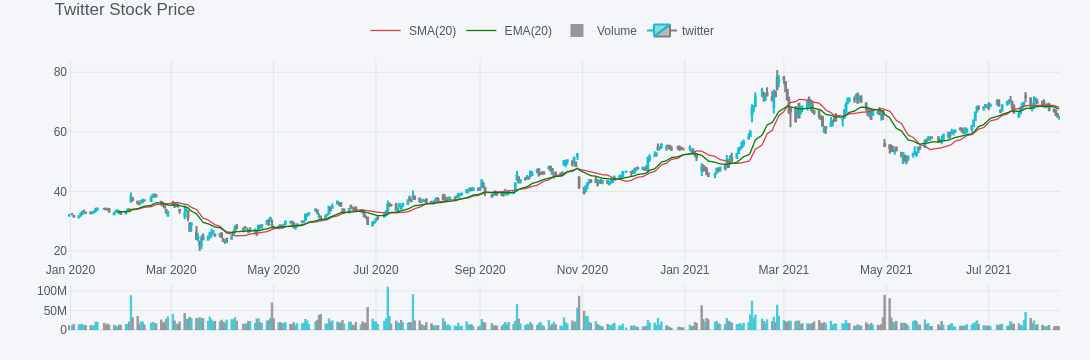

In [3]:
# plotly 활성화 하기
import cufflinks as cf
from plotly.offline import iplot, init_notebook_mode
cf.set_config_file(world_readable=True, theme='pearl', offline=True) # set up settings (run it once)
init_notebook_mode()

# 수집한 데이터를 활용하여 그림 그리기 (1.캔들차트, 2.거래량, 3,4.이동평균 곡선)
# SMA : 단순 이동 평균 (Simple Moving Average)
# EMA : 지수 이동 평균 (Exponential Moving Average)
qf = cf.QuantFig(df_twiter, title='Twitter Stock Price', legend='top', name='twitter')
qf.add_sma(periods=20, column='Close', color='red')
qf.add_ema(periods=20, color='green')
qf.add_volume()
qf.iplot()

<br/>

## **2 Back Testing 시작하기**
- **[BackTesting with PANDAS](https://towardsdatascience.com/backtest-trading-strategies-with-pandas-vectorized-backtesting-26001b0ba3a5)**
- **[다중 데이터 BackTesting](https://jsp-dev.tistory.com/104)**
- **[matplotlib Warning Error Fix](https://community.backtrader.com/topic/981/importerror-cannot-import-name-min_per_hour-when-trying-to-plot/8)**
- 단순 이동평균 전략등 다양한 전략을 간편하게 Simulation 가능
- 보조적인 기술적 지표를 활용한 매매분석에 용이

### **01 Loading the DataSet**

In [4]:
DATA_FILENAME = 'data/stock-apple.pkl'
import pandas as pd
import yfinance as yf
try:
    data_csv = pd.read_pickle(DATA_FILENAME)
except FileNotFoundError:
    data_csv = yf.download('TWTR', start='2020-01-01', end='2022-12-31', progress=False)
    data_csv.to_pickle(DATA_FILENAME)
data_csv.head(3)

Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2019-12-31  31.860001  32.320000  31.770000  32.049999  32.049999  11050600
2020-01-02  32.310001  32.500000  31.959999  32.299999  32.299999  10721100
2020-01-03  31.709999  32.099998  31.260000  31.520000  31.520000  14429500

### **02 Converting The Price DataSet**
loading from CSV to **<span style="color:red;">Pandas DataFrame<span>** of the BackTrader DataSet.
- https://www.backtrader.com/docu/datafeed/

In [5]:
# Back Trading 전략에 DataFrame 데이터로 Simulation 합니다.
import backtrader as bt
data_stock = bt.feeds.PandasData(dataname = data_csv)
type(data_stock)

backtrader.feeds.pandafeed.PandasData

<br/>

## **3 1개 기준선을 활용한 Back Testing 1**
- 종가가 20일 SMA 보다 높으면 매수를 한다
- 종가가 20일 SMA 보다 낮으면 보유한 주식을 매도한다
- 주식 매매는 1주만 허용 된다

### **01 Strategy SIGNAL Class**
- **SMA Signal's Class** 를 정의하고, BackTesting 진행한다

In [6]:
# Signal Class 를 정의합니다.
# => 20일 이동평균선 전략을 정의 합니다.
class SmaSignal(bt.Signal):
    params = (('period', 20), )
    
    def __init__(self):
        self.lines.signal = self.data - bt.ind.SMA(period=self.p.period)

In [7]:
# Back Testing 을 설정에 추가합니다
cerebro = bt.Cerebro(stdstats=False)
cerebro.adddata(data_stock) # Add the data feed 
cerebro.broker.setcash(1000.0)
cerebro.add_signal(bt.SIGNAL_LONG, SmaSignal)
cerebro.addobserver(bt.observers.BuySell)
cerebro.addobserver(bt.observers.Value)

# Back Testing 실행 결과를 계산 합니다.
print(f'Starting Portfolio Value : {cerebro.broker.getvalue():.2f}')
cerebro.run()
print(f'Final Portfolio Value: {cerebro.broker.getvalue():.2f}')

Starting Portfolio Value : 1000.00
Final Portfolio Value: 1035.30


### **02 Visualization**
- **[matplotlib Warning Error Fix](https://community.backtrader.com/topic/981/importerror-cannot-import-name-min_per_hour-when-trying-to-plot/8)**
- **[matplotlib Warning Error Fix2](https://community.backtrader.com/topic/2881/cannot-import-name-warnings-from-matplotlib-dates)**

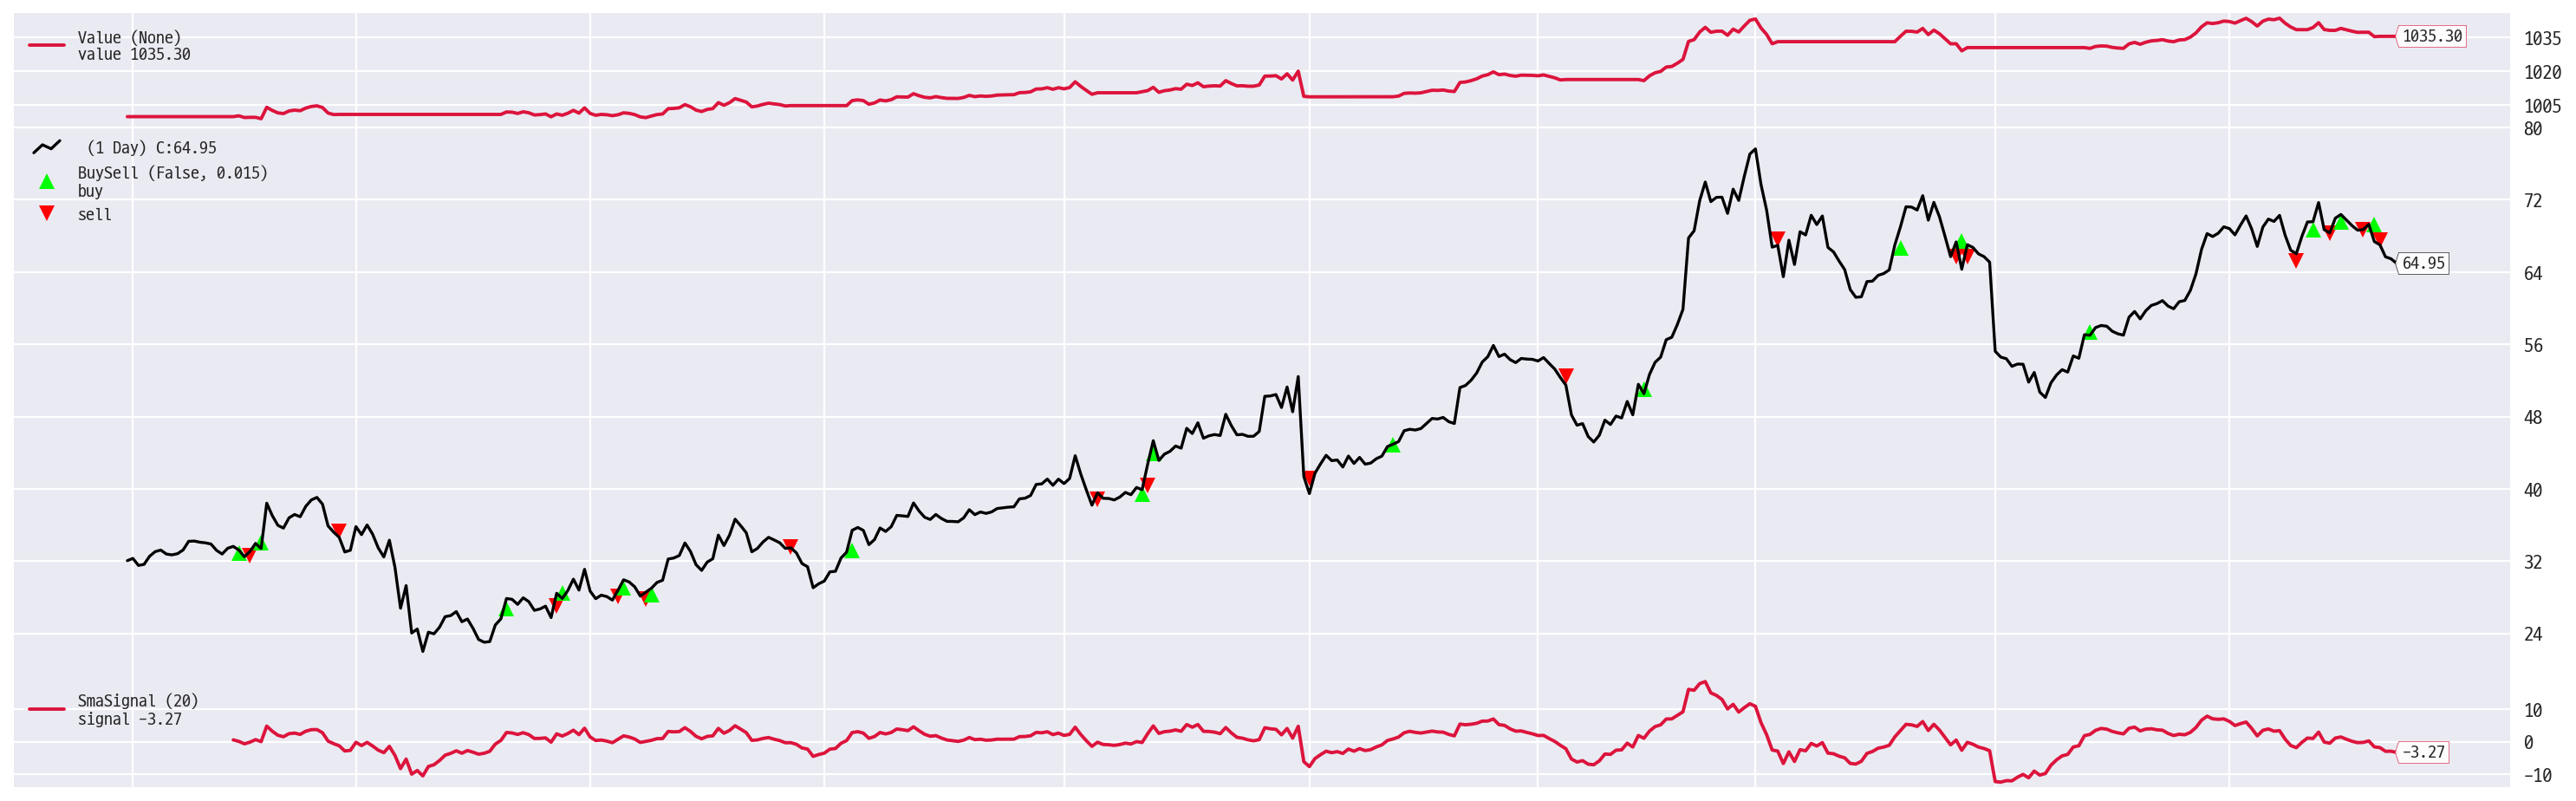

In [8]:
plt.rcParams['figure.dpi'] = 80
plt.rcParams['figure.figsize'] = [20, 6]
cerebro.plot(iplot=False, volume=False)
plt.show()

<br/>

## **4 2개의 이동평균을 활용한 Back Testing**
- 단기 (10일) SMA 가 장기(30일) 보다 높아질 때 매수한다
- 장기 (30일) SMA 가 단기(10일) 보다 높아질 때 매도한다

### **01 Strategy SIGNAL Class**
- **SMA Signal's Class** 를 정의하고, BackTesting 진행한다

In [9]:
import backtrader as bt

# 이동평균선 전략을 정의 합니다.
class SmaCross(bt.Strategy): 
    params = dict(
        pfast=10, # fast moving average 
        pslow=30) # slow moving average 
    
    def __init__(self):
        sma1 = bt.ind.SMA(period=self.p.pfast)
        sma2 = bt.ind.SMA(period=self.p.pslow)
        self.crossover = bt.ind.CrossOver(sma1, sma2) # crossover signal 
        
    def next(self): 
        if not self.position:      # not in the market 
            if self.crossover > 0: # if fast crosses slow to the upside 
                self.buy()         # enter long (매수 진행한다)
                
        elif self.crossover < 0: # in the market & cross to the downside 
            self.close()         # close long position (보유시 매도를 진행한다)

In [10]:
# 위 Back Trading 전략에 DataFrame 데이터로 Simulation 합니다.
cerebro = bt.Cerebro()        # create a "Cerebro" engine instance 
cerebro.adddata(data_stock)   # Add the data feed 
cerebro.addstrategy(SmaCross) # Add the trading strategy

# backtest 를 실행한다.
print(f'Starting Portfolio Value : {cerebro.broker.getvalue():.2f}')
cerebro.run() # run it all 
print(f'Final Portfolio Value: {cerebro.broker.getvalue():.2f}')

Starting Portfolio Value : 10000.00
Final Portfolio Value: 10010.79


### **02 Visualization**

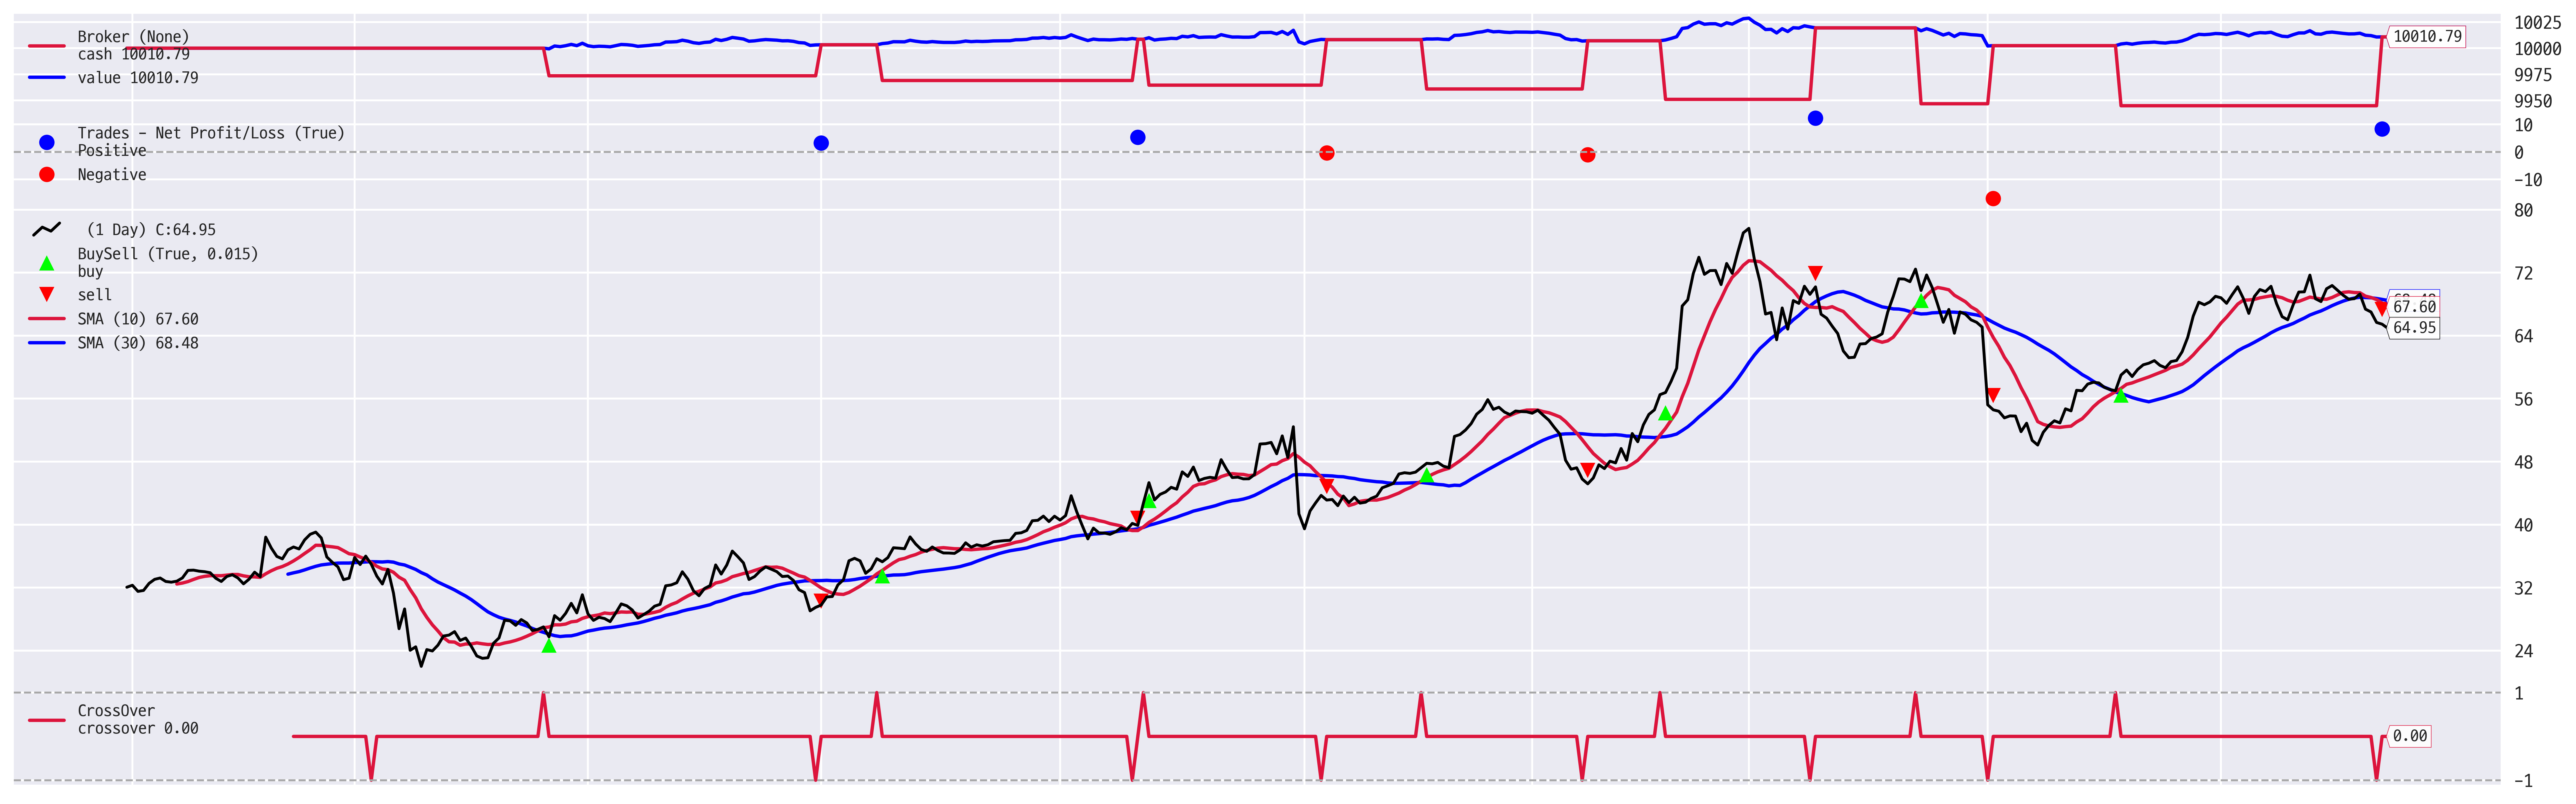

In [11]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = [20, 6]
cerebro.plot(iplot=False, volume=False)
plt.show()

<br/>

## **5 1개 기준선을 활용한 Back Testing2**
- 종가가 20일 SMA 보다 높으면 매수를 한다
- 종가가 20일 SMA 보다 낮으면 보유한 주식을 매도한다
- 주식 매매는 1주만 허용 된다

### **01 Strategy SIGNAL Class**
- **SMA Signal's Class** 를 정의하고, BackTesting 진행한다
- 매수, 매도 실행시 세부조건을 설정한다

In [12]:
class SmaStrategy(bt.Strategy):
    params = (('ma_period', 20), )

    def __init__(self):
        # keep track of pending orders/buy price/buy commission
        self.data_close = self.datas[0].close  # Series 에서 close 추출
        self.order = None
        self.price = None
        self.comm = None
        self.sma = bt.ind.SMA( # add a simple moving average indicator
            self.datas[0], period=self.params.ma_period)
        
    def log(self, txt):
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f'{dt}, {txt}')

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # order already submitted/accepted - no action required
            return

        # report executed order
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Commission: {order.executed.comm:.2f}')
                self.price = order.executed.price
                self.comm = order.executed.comm
            else:
                self.log(f'SELL EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Commission: {order.executed.comm:.2f}')

        # report failed order
        elif order.status in [
            order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Failed')

        # set no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log(f'OPERATION RESULT --- Gross: {trade.pnl:.2f}, Net: {trade.pnlcomm:.2f}')

    def next(self):
        # do nothing if an order is pending
        if self.order:
            return

        # check if there is already a position
        if not self.position:
            # buy condition
            if self.data_close[0] > self.sma[0]:
                self.log(f'BUY CREATED --- Price: {self.data_close[0]:.2f}')
                self.order = self.buy()
        else:
            # sell condition
            if self.data_close[0] < self.sma[0]:            
                self.log(f'SELL CREATED --- Price: {self.data_close[0]:.2f}')
                self.order = self.sell()

In [13]:
cerebro = bt.Cerebro(stdstats = False)
cerebro.adddata(data_stock) # Add the data feed 
cerebro.broker.setcash(1000.0)
cerebro.addstrategy(SmaStrategy)
cerebro.addobserver(bt.observers.BuySell)
cerebro.addobserver(bt.observers.Value)

print(f'Starting Portfolio Value: {cerebro.broker.getvalue():.2f}')
cerebro.run()
print(f'Final Portfolio Value: {cerebro.broker.getvalue():.2f}')

Starting Portfolio Value: 1000.00
2020-01-29, BUY CREATED --- Price: 33.63
2020-01-30, BUY EXECUTED --- Price: 32.86, Cost: 32.86, Commission: 0.00
2020-01-31, SELL CREATED --- Price: 32.48
2020-02-03, SELL EXECUTED --- Price: 32.56, Cost: 32.86, Commission: 0.00
2020-02-03, OPERATION RESULT --- Gross: -0.30, Net: -0.30
2020-02-04, BUY CREATED --- Price: 33.96
2020-02-05, BUY EXECUTED --- Price: 34.00, Cost: 34.00, Commission: 0.00
2020-02-25, SELL CREATED --- Price: 35.21
2020-02-26, SELL EXECUTED --- Price: 35.28, Cost: 34.00, Commission: 0.00
2020-02-26, OPERATION RESULT --- Gross: 1.28, Net: 1.28
2020-04-07, BUY CREATED --- Price: 25.61
2020-04-08, BUY EXECUTED --- Price: 26.79, Cost: 26.79, Commission: 0.00
2020-04-21, SELL CREATED --- Price: 25.75
2020-04-22, SELL EXECUTED --- Price: 27.00, Cost: 26.79, Commission: 0.00
2020-04-22, OPERATION RESULT --- Gross: 0.21, Net: 0.21
2020-04-22, BUY CREATED --- Price: 28.44
2020-04-23, BUY EXECUTED --- Price: 28.43, Cost: 28.43, Commissio

### **02 Visualization**
- https://community.backtrader.com/topic/2881/cannot-import-name-warnings-from-matplotlib-dates

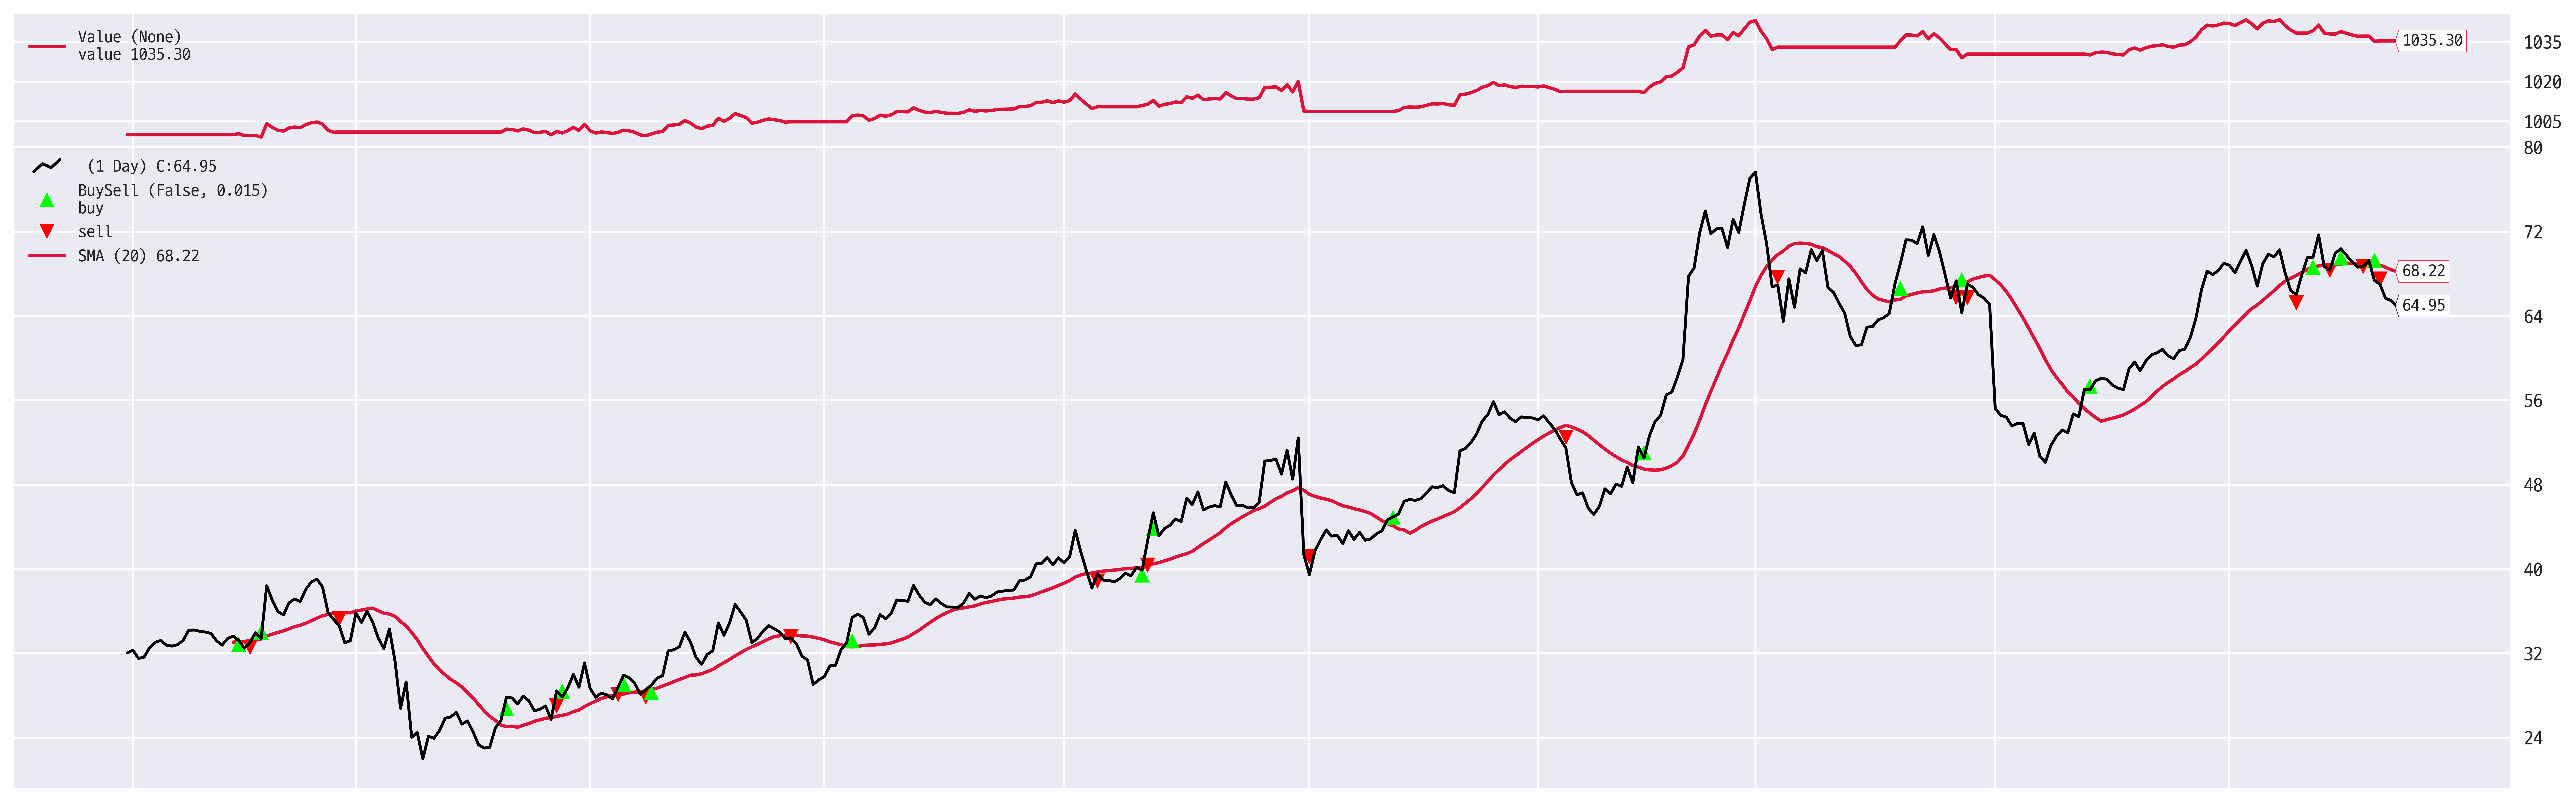

In [14]:
cerebro.plot(iplot=False)
plt.show()